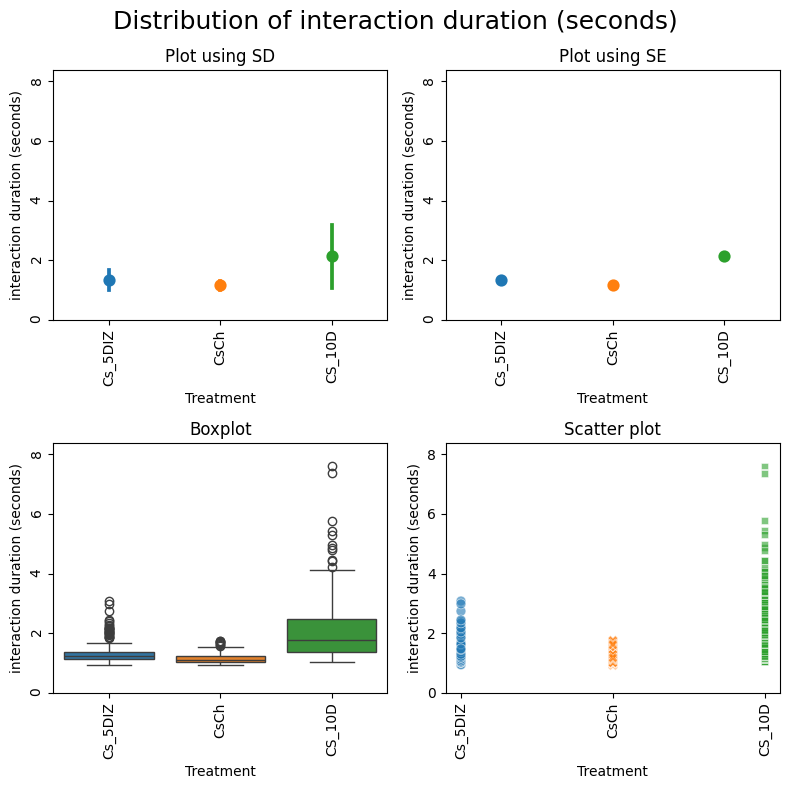

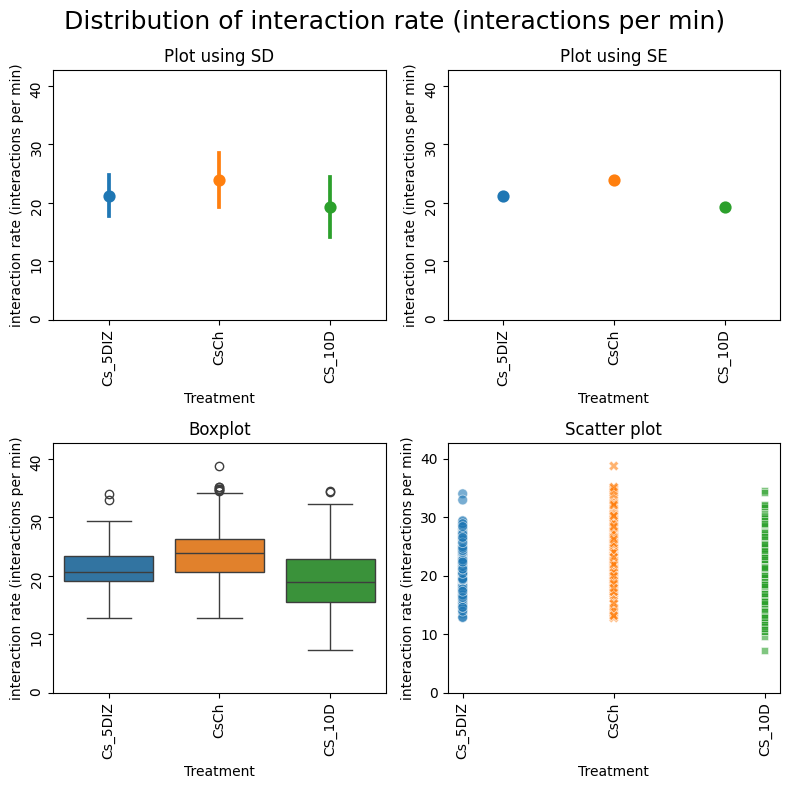

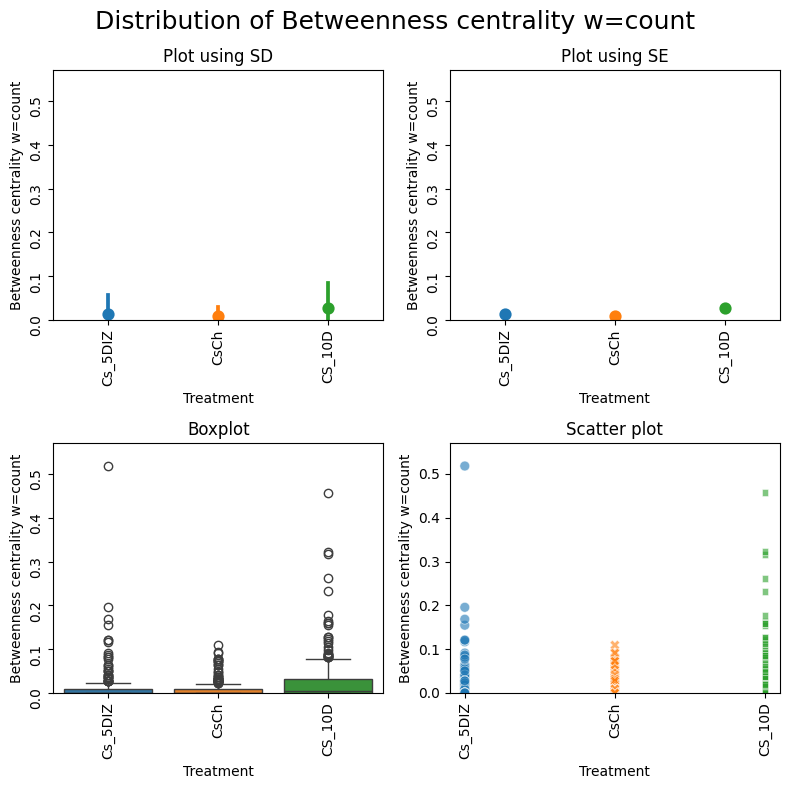

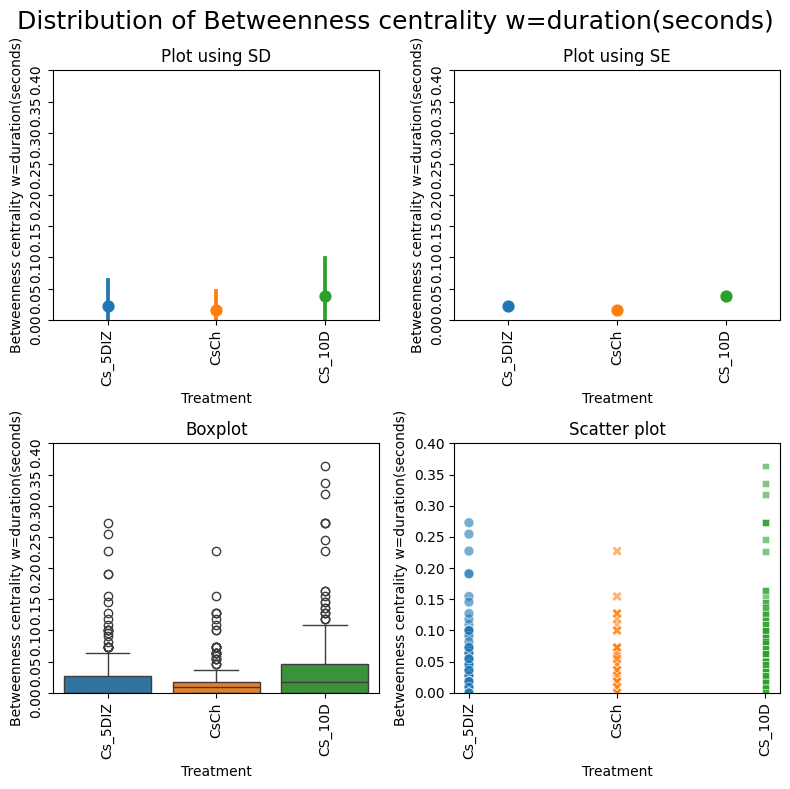

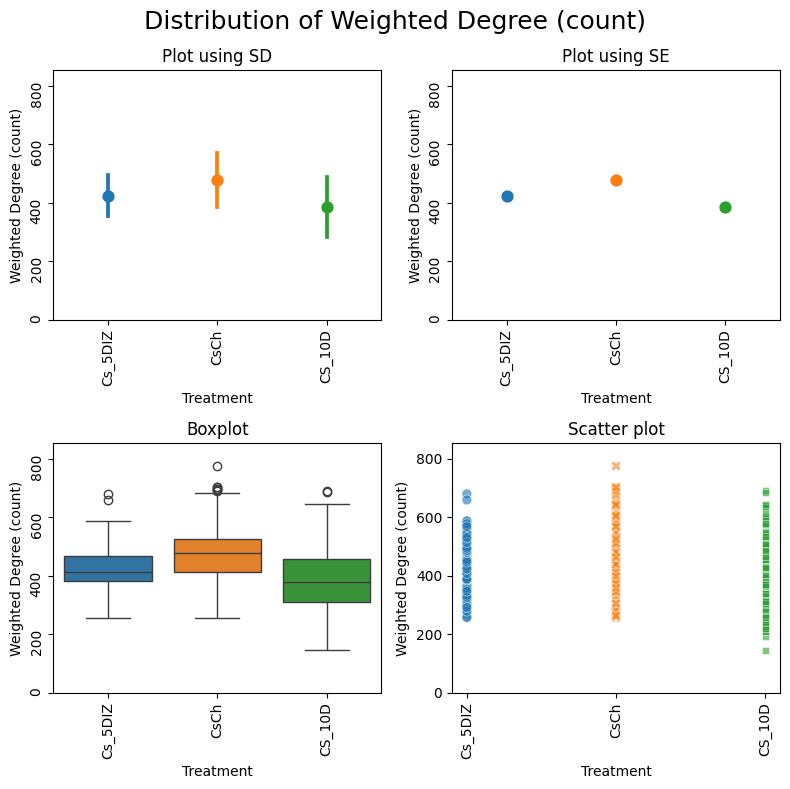

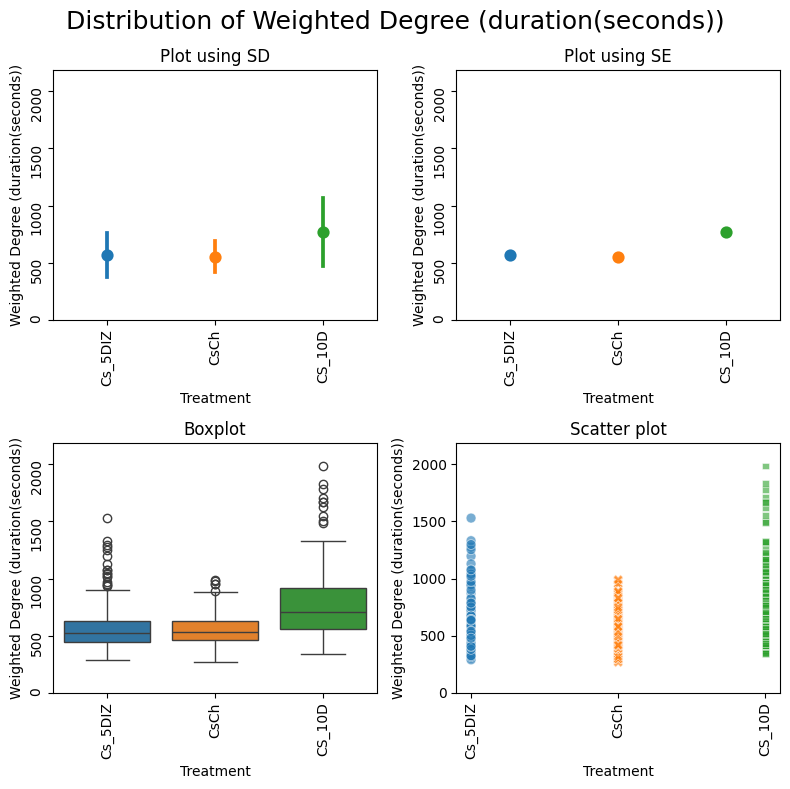

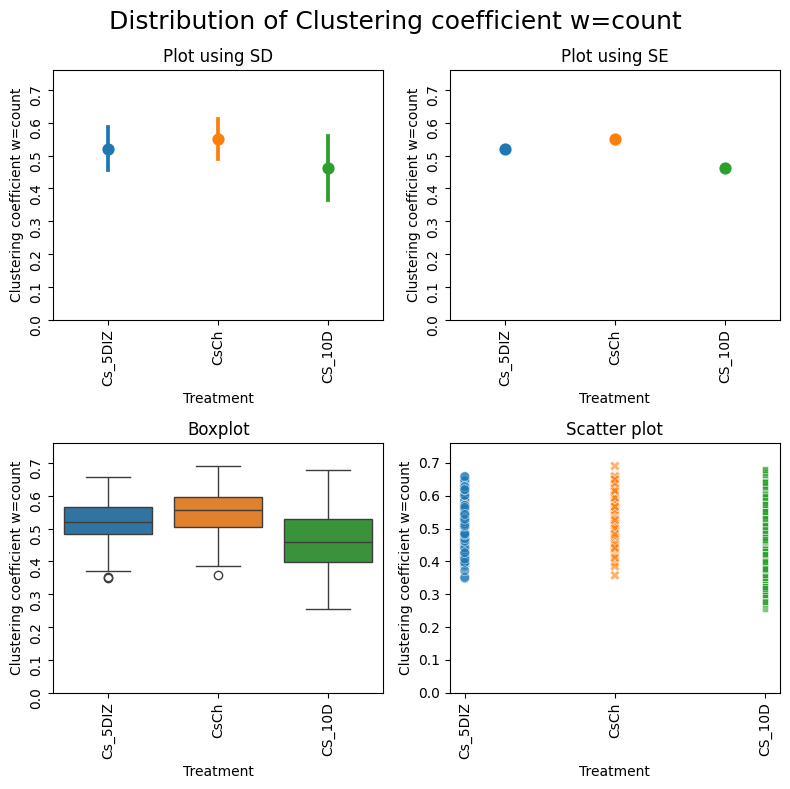

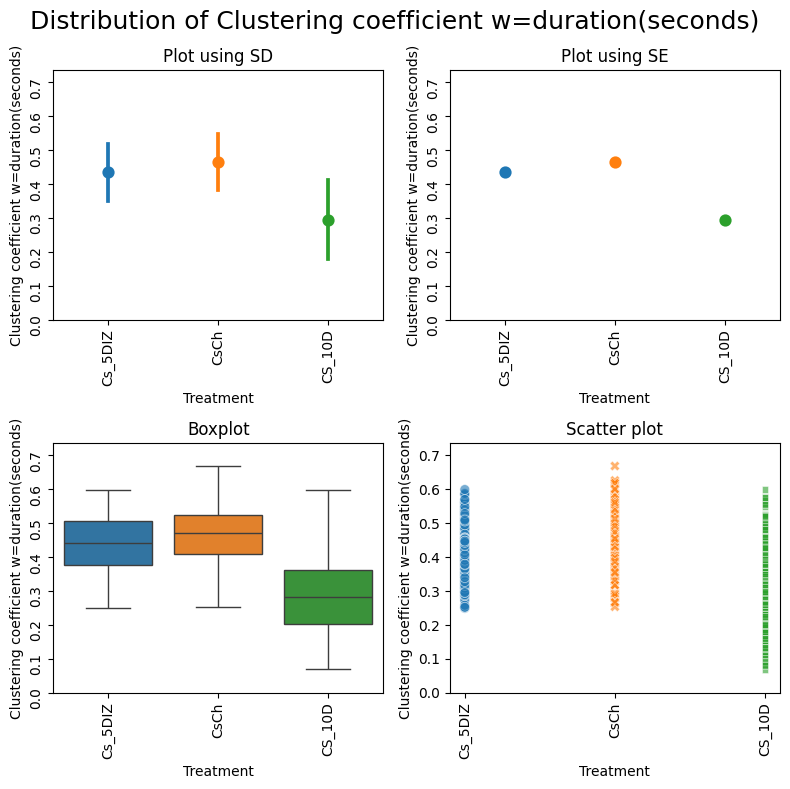

In [2]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from src import settings
from src.utils import fileio

config = fileio.get_config(settings.CONFIG_NAME)

TREATMENTS = config["TREATMENTS"]

INPUT_PATH = os.path.join(settings.RESULTS_DIR, "local_measures")
all_treatments = fileio.load_multiple_folders(INPUT_PATH)
all_treatments = {key: value for key, value in all_treatments.items() if key.replace(".csv", "") in TREATMENTS}

OUTPUT_DIR = os.path.join(settings.REPORTS_DIR, "figures", "levine_lab_measures")
os.makedirs(OUTPUT_DIR, exist_ok=True)

treatment_dataframes = pd.DataFrame()
for treatment_name, treatment_path in all_treatments.items():
    all_groups = fileio.load_files_from_folder(treatment_path)

    for group_name, group_path in all_groups.items():
        df = pd.read_csv(group_path, index_col=0)
        df.rename_axis("Fly")
        df["Treatment"] = treatment_name
        df["Group"] = group_name.replace(".csv", "")
        treatment_dataframes = pd.concat([treatment_dataframes, df])

treatment_dataframes = treatment_dataframes.set_index("Treatment", append=True)
treatment_dataframes = treatment_dataframes.set_index("Group", append=True)
combined_data_reset = treatment_dataframes.reset_index()

combined_data_reset["interaction duration (seconds)"] = (
    combined_data_reset["Weighted Degree (duration(seconds))"] / combined_data_reset["Weighted Degree (count)"]
)
combined_data_reset["interaction rate (interactions per min)"] = combined_data_reset["Weighted Degree (count)"] / (
    config["EXPERIMENT_DURATION"] / 60
)

measures = [
    "interaction duration (seconds)",
    "interaction rate (interactions per min)",
    "Betweenness centrality w=count",
    "Betweenness centrality w=duration(seconds)",
    "Weighted Degree (count)",
    "Weighted Degree (duration(seconds))",
    "Clustering coefficient w=count",
    "Clustering coefficient w=duration(seconds)",
]

i = 0
for measure_name in measures:
    treatment_sums = {}
    for treatment in config["TREATMENTS"]:
        treatment_sums[f"sum_{treatment}"] = combined_data_reset[combined_data_reset["Treatment"] == treatment][
            measure_name
        ]

    # anova_result = scipy.stats.f_oneway(*treatment_sums.values())

    all_data = np.concatenate([*treatment_sums.values()])
    group_labels = []
    for treatment in config["TREATMENTS"]:
        group_labels.extend(
            [treatment] * len(combined_data_reset[combined_data_reset["Treatment"] == treatment][measure_name])
        )

        # tukey_results = pairwise_tukeyhsd(all_data, group_labels)

    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    plt.suptitle(f"Distribution of {measure_name}", fontsize=18)

    sns.pointplot(
        data=combined_data_reset,
        x="Treatment",
        y=measure_name,
        dodge=False,
        hue="Treatment",
        errorbar="sd",
        ax=axes[0, 0],
    )
    axes[0, 0].set_title("Plot using SD")
    axes[0, 0].set_xlabel("Treatment")
    axes[0, 0].set_ylabel(measure_name)
    axes[0, 0].tick_params(rotation=90)
    axes[0, 0].set_ylim(0, combined_data_reset[measure_name].max() * 1.1)

    sns.pointplot(
        data=combined_data_reset,
        x="Treatment",
        y=measure_name,
        dodge=False,
        hue="Treatment",
        errorbar="se",
        ax=axes[0, 1],
    )
    axes[0, 1].set_title("Plot using SE")
    axes[0, 1].set_xlabel("Treatment")
    # axes[0, 1].set_ylabel(measure_name)
    axes[0, 1].tick_params(rotation=90)
    axes[0, 1].set_ylim(0, combined_data_reset[measure_name].max() * 1.1)

    sns.boxplot(
        data=combined_data_reset,
        x="Treatment",
        y=measure_name,
        dodge=False,
        hue="Treatment",
        ax=axes[1, 0],
    )

    axes[1, 0].set_title(f"Boxplot")
    axes[1, 0].set_xlabel("Treatment")
    axes[1, 0].set_ylabel(measure_name)
    axes[1, 0].tick_params(rotation=90)
    axes[1, 0].set_ylim(0, combined_data_reset[measure_name].max() * 1.1)
    # axes[1, 0].legend("")

    sns.scatterplot(
        data=combined_data_reset,
        x="Treatment",
        y=measure_name,
        hue="Treatment",
        ax=axes[1, 1],
        s=50,
        alpha=0.6,
        markers=True,
        style="Treatment",
        legend=False,
    )

    per_group = len(combined_data_reset) / len(all_treatments)
    locations_x = [per_group / 2 + (per_group * x) for x in range(0, len(all_treatments))]

    axes[1, 1].set_title("Scatter plot")
    # axes[1, 1].legend(loc="center left", bbox_to_anchor=(1, 0.5), title="Treatment", labels=config["TREATMENTS"])
    axes[1, 1].set_xlabel("Treatment")
    # axes[1, 1].set_xticks(locations_x)
    # axes[1, 1].xaxis.set_ticks(locations_x)
    # axes[1, 1].set_xticklabels(config["TREATMENTS"])
    axes[1, 1].tick_params(axis="x", rotation=90)
    # axes[1, 1].set_ylabel(measure_name)
    axes[1, 1].set_ylim(0, combined_data_reset[measure_name].max() * 1.1)

    plt.tight_layout()

    save_path = os.path.join(OUTPUT_DIR, f"{measure_name}.png")
    plt.savefig(save_path)

    plt.show()